# **Sistema di Face Detection per una fotocamera digitale**

# **Contesto del Progetto**
La ProCam S.p.A. è pronta a lanciare una nuova fotocamera digitale compatta, accessibile e pensata per i giovani appassionati di fotografia. L'obiettivo principale del prodotto è facilitare l'esperienza di scatto, in particolare per i selfie con una o più persone.

# **Sfida**
Sei stato assunto come Data Scientist per sviluppare un sistema di rilevamento volti nelle immagini, che aiuterà i tecnici a ottimizzare automaticamente le impostazioni della fotocamera durante i selfie. Il tuo compito è realizzare una pipeline che identifichi i volti presenti nelle immagini e restituisca le coordinate dei bounding box dove i volti sono individuati. Se non ci sono volti, la pipeline restituirà una lista vuota.

Si tratta di un problema di Computer Vision, più precisamente di Face Detection.

# **Requisiti del Progetto**

1. *Obiettivo*: Costruire un sistema di rilevamento dei volti utilizzando Scikit-learn. La pipeline deve essere in grado di:


*   Prendere un’immagine in ingresso.
*   Restituire una lista di coordinate dei bounding box dove sono presenti volti.
*   Restituire una lista vuota se nell’immagine non ci sono volti.

2. *Limitazioni*:

*   Dataset: Non ti viene fornito un dataset. Devi cercare un dataset adatto in rete o, in mancanza di alternative, costruirlo tu stesso.

*   Modelli pre-addestrati: Non è consentito utilizzare modelli pre-addestrati. Il modello di Face Detection dovrà essere addestrato da zero con Scikit-learn.

*   Risorse di calcolo: Lavorerai su un sistema con capacità di calcolo limitate. Il modello dovrà essere ottimizzato per utilizzare poche risorse.

3. *Documentazione*: La soluzione deve essere ben documentata. Ogni decisione adottata (scelta degli algoritmi, preprocessamento, tecniche di ottimizzazione) dovrà essere spiegata. Inoltre, ogni risorsa esterna utilizzata (paper accademici, articoli di blog, codice GitHub) dovrà essere citata.

4. *Ricerca bibliografica*: Poiché non ti vengono fornite indicazioni dettagliate sull'implementazione, è essenziale condurre un'approfondita ricerca bibliografica per identificare le soluzioni migliori. Dovrai analizzare approcci già esistenti e adattarli alle limitazioni del progetto.

Ho scelto di utilizzare due dataset complementari per creare un dataset bilanciato:

**LFW** ([Labeled Faces in the Wild](https://www.kaggle.com/datasets/jessicali9530/lfw-dataset)) per i campioni positivi (volti):
*  13.233 immagini totali disponibili
*  Volti in condizioni non controllate (illuminazione variabile, pose diverse)
*   Risoluzione variabile: da 250x250 a dimensioni maggiori


---


**[Natural Images Dataset](https://www.kaggle.com/datasets/prasunroy/natural-images)** per i campioni negativi (non-volti):
*   8 categorie: airplane, car, cat, dog, flower, fruit, motorbike, person
*   Ho escluso la categoria "person" per evitare contaminazioni
*   Circa 1000 immagini per categoria



Per garantire un training bilanciato, ho selezionato 3.000 immagini per ciascuna classe.  Inoltre il SEED fisso garantisce riproducibilità

In [ ]:
# utilities
import os
import json
import shutil
import random
import joblib
import glob
import imutils
import io
from random import sample # for data selection

# array operations
import numpy as np

# image processing
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

# process tracking
from tqdm import tqdm

#visualization
import matplotlib.pyplot as plt

# file upload in colab
from google.colab import files

In [ ]:
_ = files.upload() # loading kaggle.json

with open('kaggle.json') as f:
  kaggle_cred = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_cred['username']
os.environ['KAGGLE_KEY'] = kaggle_cred['key']

Saving kaggle.json to kaggle.json


### ***FACES DATASET***

In [ ]:
!kaggle datasets download -d jessicali9530/lfw-dataset
!unzip /content/lfw-dataset.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0027.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0028.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0029.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Sil

In [ ]:
faces_dir = '/content/faces'
source_dir = '/content/lfw-deepfunneled/lfw-deepfunneled'  # source dir of LFW dataset

os.makedirs(faces_dir, exist_ok=True) # create destination folder if it doesn't exist

In [ ]:
# find all faces images
all_images = []
for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_images.append(os.path.join(root, file))
print(f"Total images: {len(all_images)}")

# randomly select 3000 images
random.seed(42)
num_to_select = min(3000, len(all_images))
selected_images = sample(all_images, num_to_select)
print(f"Selected images: {len(selected_images)} ")

# move selected images
count = 0
for src_path in tqdm(selected_images, desc="Moving faces images"):
    file = os.path.basename(src_path)
    dest_path = os.path.join(faces_dir, file)

    try:
        shutil.move(src_path, dest_path)
        count += 1
    except Exception as e:
        print(f"Error while moving {file}: {e}")

print(f"\nMoved {count} files in {faces_dir}")

Total images: 13233
Selected images: 3000 


Moving faces images: 100%|██████████| 3000/3000 [00:00<00:00, 32905.36it/s]


Moved 3000 files in /content/faces


### ***NON FACES DATASET***

In [ ]:
!kaggle datasets download -d prasunroy/natural-images
!unzip /content/natural-images.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: natural_images/cat/cat_0204.jpg  
  inflating: natural_images/cat/cat_0205.jpg  
  inflating: natural_images/cat/cat_0206.jpg  
  inflating: natural_images/cat/cat_0207.jpg  
  inflating: natural_images/cat/cat_0208.jpg  
  inflating: natural_images/cat/cat_0209.jpg  
  inflating: natural_images/cat/cat_0210.jpg  
  inflating: natural_images/cat/cat_0211.jpg  
  inflating: natural_images/cat/cat_0212.jpg  
  inflating: natural_images/cat/cat_0213.jpg  
  inflating: natural_images/cat/cat_0214.jpg  
  inflating: natural_images/cat/cat_0215.jpg  
  inflating: natural_images/cat/cat_0216.jpg  
  inflating: natural_images/cat/cat_0217.jpg  
  inflating: natural_images/cat/cat_0218.jpg  
  inflating: natural_images/cat/cat_0219.jpg  
  inflating: natural_images/cat/cat_0220.jpg  
  inflating: natural_images/cat/cat_0221.jpg  
  inflating: natural_images/cat/cat_0222.jpg  
  inflating: natural_images/cat/cat_0223.jpg  
  inflatin

In [ ]:
target_folder = '/content/natural_images'
non_faces_dir = '/content/non_faces'

os.makedirs(non_faces_dir, exist_ok=True)

In [ ]:
# Find all non-face images
all_images = []
for foldername in os.listdir(target_folder):
    folder_path = os.path.join(target_folder, foldername)
    if foldername != 'person' and os.path.isdir(folder_path):
        print(f"Scanning folder: {foldername}")
        folder_images = []
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                full_path = os.path.join(folder_path, filename)
                all_images.append(full_path)
                folder_images.append(filename)
        print(f"Found {len(folder_images)} images")

print(f"\nTotal non-face images found: {len(all_images)}")

# Randomly select 3000 images
random.seed(42)
num_to_select = min(3000, len(all_images))
selected_images = sample(all_images, num_to_select)
print(f"Selected {num_to_select} images for copying")

# Copy selected images to non-faces directory
count = 0
for src_path in tqdm(selected_images, desc="Copying non-face images"):
    file = os.path.basename(src_path)
    dest_path = os.path.join(non_faces_dir, file)

    try:
        shutil.copy(src_path, dest_path)
        count += 1
    except Exception as e:
        print(f"Error while copying {file}: {e}")

print(f"\nSuccessfully copied {count} images to {non_faces_dir}")

Scanning folder: flower
Found 843 images
Scanning folder: motorbike
Found 788 images
Scanning folder: cat
Found 885 images
Scanning folder: dog
Found 702 images
Scanning folder: car
Found 968 images
Scanning folder: airplane
Found 727 images
Scanning folder: fruit
Found 1000 images

Total non-face images found: 5913
Selected 3000 images for copying


Copying non-face images: 100%|██████████| 3000/3000 [00:00<00:00, 7912.38it/s]


Successfully copied 3000 images to /content/non_faces


In [ ]:
def normalize_image(folder_path, batch_size=8, target_size=(64, 64)):

  # Find all .jpg files in the specified folder
    image_paths = glob.glob(os.path.join(folder_path, "*.jpg"))

    images = []

    # Process images in batches
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]

        for img_path in batch_paths:
          img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # Read the image in grayscale
          img = cv2.resize(img, target_size)  # Resize image to target size
          images.append(img / 255.0) # Normalize pixels from [0, 255] to [0, 1]

    return np.array(images, dtype=np.float32)

In [ ]:
non_faces = normalize_image(non_faces_dir, batch_size=8, target_size=(64, 64))

In [ ]:
faces = normalize_image(faces_dir, batch_size=8, target_size=(64, 64))

In [ ]:
print(f"Non-faces shape: {non_faces.shape}")
print(f"Faces shape: {faces.shape}")

Non-faces shape: (3000, 64, 64)
Faces shape: (3000, 64, 64)


## **MODEL**

In [ ]:
%%time
# Merge face and non-face images into a single input array X
X = np.concatenate((faces, non_faces))

# I create the y labels: 1 for images with faces, 0 for images without faces
y = np.concatenate((np.ones(len(faces)), np.zeros(len(non_faces))))

CPU times: user 15.7 ms, sys: 29.1 ms, total: 44.8 ms
Wall time: 44.8 ms


In [ ]:
# Split the dataset into training and test sets
# 80% of the data for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(4800, 64, 64)
(1200, 64, 64)


4800 immagini da 64x64 pixel (training set)

1200 immagini da 64x64 pixel (test set)

## **HOG**

Ho scelto HOG (Histogram of Oriented Gradients) come estrattore di feature principale perché, come dimostrato da [Dalal e Triggs](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf) (2005), questa tecnica offre una rappresentazione solida e robusta per il riconoscimento di oggetti deformabili, volti inclusi.

In [ ]:
def extract_hog_features(images, batch_size=50):

    hog_features_batches = []

    # Process images in batches to optimize memory and speed
    for i in range(0, len(images), batch_size):
        batch_images = images[i:i + batch_size]

        # Resize each image to 64x64 pixels
        resized_images = [cv2.resize(img, (64, 64)) for img in batch_images]

        # Extract HOG features
        batch_hog_features = [hog(img, orientations=8, pixels_per_cell=(16, 16),
                             cells_per_block=(2, 2), visualize=False)
                         for img in resized_images]

        hog_features_batches.append(np.array(batch_hog_features))

    return np.concatenate(hog_features_batches, axis=0)

In [ ]:
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

Presento alcune immagini di esempio con la rispettiva rappresentazione HOG

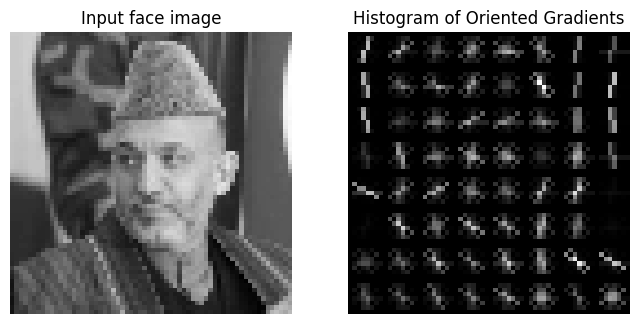

In [ ]:
image=X[15]

hog_features, hog_image = hog(image=image,
                    orientations=9,
                    pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2),
                    visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input face image')
ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
print('')
plt.show()

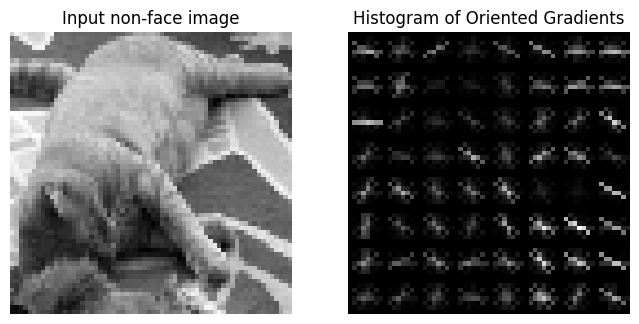

In [ ]:
image=X[4800]

hog_features, hog_image = hog(image=image,
                    orientations=9,
                    pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2),
                    visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input non-face image')
ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
print('')
plt.show()

In [ ]:
print(X_train_hog.shape)
print(X_test_hog.shape)

(4800, 288)
(1200, 288)


## **FACE CLASSIFIER**

Ho scelto di usare le **SVM** (***Support Vector Machines***) per la face detection perché sono modelli semplici ma efficaci nel distinguere tra immagini di volti e non-volti. Funzionano bene anche con dataset non troppo grandi e, combinate con tecniche di estrazione delle caratteristiche come HOG, permettono di ottenere buoni risultati anche in condizioni non ottimali.

In [ ]:
# Linear SVM model with C=0.1 regularization
svm_model = SVC(kernel='linear', C=0.1, probability=True, random_state=42)

# I train the model with HOG features and labels
svm_model.fit(X_train_hog, y_train)

SVC(C=0.1, kernel='linear', probability=True, random_state=42)

In [ ]:
y_pred = svm_model.predict(X_test_hog)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=2))

Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       587
         1.0       0.96      0.94      0.95       613

    accuracy                           0.95      1200
   macro avg       0.95      0.95      0.95      1200
weighted avg       0.95      0.95      0.95      1200



Il modello mostra ottime performance:

- per la classe “*non faces*” ha una precisione del 94%, e un recall del 96%.

- per i volti (*faces*), la precisione è ancora più alta, al 96%, mentre il recall del 94%.

L’F1-score intorno al 95% conferma che precisione e recall sono ben bilanciati.

Infine con un’accuratezza totale del 95%, il modello è davvero solido nel distinguere volti da non volti senza fare molti errori.

In [ ]:
# Save the model with joblib
joblib.dump(svm_model, 'face_classifier.joblib')

['face_classifier.joblib']

## **FACE DETECTION**

Collego il mio Google Drive a Colab così posso prendere i file direttamente dal Drive senza doverli caricare a mano ogni volta. Uso drive.mount('/content/drive') per far comparire il mio Drive dentro Colab, e poi con TEST_IMAGES_DIR dico esattamente dove ho messo le immagini di test.

In [ ]:
from google.colab import drive
TEST_IMAGES_DIR = '/content/drive/MyDrive/test_images'

Setto i parametri per la sliding window, cioè la finestra che scorre sull’immagine per cercare i volti. La finestra è di 150x150 pixel e la sposto di 16 pixel ogni volta. Quando cerco volti più piccoli, riduco la finestra del 20% a ogni passaggio. Uso una soglia di sovrapposizione bassa, 0.20, per unire i rilevamenti troppo vicini, e accetto solo volti con confidenza altissima, almeno 0.98. Infine, carico il modello SVM che ho salvato prima, ‘face_classifier.joblib’, per fare le predizioni.

In [ ]:
SLIDINGWINDOW_W, SLIDINGWINDOW_H = 150, 150
SLIDINGWINDOW_STEP_SIZE = 16
SLIDINGWINDOW_SCALE_FACTOR = 0.8
SLIDINGWINDOW_THRESH_IOU = 0.20
THRESHOLD_FACE_CONFIDENCE = 0.98
MODEL_PATH = 'face_classifier.joblib'

In [ ]:
def preprocess_image(image_gray):
    # Resize the image to 64x64 pixels
    image_resized = cv2.resize(image_gray, (64, 64))

    # Normalize the pixels by dividing by 255 to have values ​​between 0 and 1
    image_normalized = image_resized.astype(np.float32) / 255.0

    # Extract HOG features from the normalized image
    features_hog = hog(image_normalized, orientations=8, pixels_per_cell=(16, 16),
                       cells_per_block=(2, 2), visualize=False)
    return features_hog

In [ ]:
def generate_scaled_pyramid(img, scale, min_img_size=(SLIDINGWINDOW_H, SLIDINGWINDOW_W)):

    pyramid_images  = []
    curr_scale = 1.0

    # Continue scaling until the image is larger than the minimum size
    while img.shape[0] >= min_img_size[1] and img.shape[1] >= min_img_size[0]:

        pyramid_images.append((curr_scale, img))
        new_width = int(img.shape[1] * scale) # Calculate the new scaled width

        img = imutils.resize(img, width=new_width)
        curr_scale *= scale # Update the overall scale factor

    return pyramid_images

In [ ]:
def sliding_window(image, step, window_dim):

    top_left_coords = []

    for y in range(0, image.shape[0] - window_dim[1] + 1, step):
        for x in range(0, image.shape[1] - window_dim[0] + 1, step):
            top_left_coords.append((x, y))

    return top_left_coords

In [ ]:
def compute_iou(box1, box2):

    # Box coordinates
    b1x1, b1y1 = box1[0]
    b1x2, b1y2 = box1[1]
    b2x1, b2y1 = box2[0]
    b2x2, b2y2 = box2[1]

    # Intersection calculation
    inter_x_max = max(b1x1, b2x1)
    inter_x_min = min(b1x2, b2x2)
    inter_y_max = max(b1y1, b2y1)
    inter_y_min = min(b1y2, b2y2)

    inter_width = max(0, inter_x_min - inter_x_max)
    inter_height = max(0, inter_y_min - inter_y_max)

    # Area calculation
    area1 = (b1x2 - b1x1) * (b1y2 - b1y1)
    area2 = (b2x2 - b2x1) * (b2y2 - b2y1)
    inter_area = inter_width * inter_height
    area_union = area1 + area2 - inter_area

    # Return IoU
    return inter_area / area_union if area_union != 0 else 0

In [ ]:
def non_maximum_suppression(bounding_boxes, thresh_IoU):

    bounding_boxes = sorted(bounding_boxes, key=lambda t: t[2])  # Sort by confidence
    final_boxes = []

    while bounding_boxes:
        best_box = bounding_boxes.pop() # Get the box with the highest confidence
        final_boxes.append(best_box)

        remaining_boxes = [] # Remove all the boxes that overlap too much
        for i, bbox in enumerate(bounding_boxes):
            if compute_iou(best_box, bbox) >= thresh_IoU:
                remaining_boxes.append(i)

        for i in sorted(remaining_boxes, reverse=True):
            bounding_boxes.pop(i)

    return final_boxes

In [ ]:
def detect_faces(img_color, svm_model):

    # Convert the image to grayscale
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

    # Generate a pyramid of images at different scales
    pyramid_images = generate_scaled_pyramid(
        img_gray,
        scale=SLIDINGWINDOW_SCALE_FACTOR,
        min_img_size=(SLIDINGWINDOW_W, SLIDINGWINDOW_H))

    bounding_boxes = []

    for curr_scale, scaled_img in pyramid_images:
        # Apply the sliding window
        windows = sliding_window(
            scaled_img,
            step=SLIDINGWINDOW_STEP_SIZE,
            window_dim=(SLIDINGWINDOW_W, SLIDINGWINDOW_H))

        for x, y in windows:
            window = scaled_img[y:y+SLIDINGWINDOW_H, x:x+SLIDINGWINDOW_W]
            if window.shape[0] != SLIDINGWINDOW_H or window.shape[1] != SLIDINGWINDOW_W:
                continue

            # HOG Extraction and Classification
            hog_features = preprocess_image(window).reshape(1, -1)
            confidence = svm_model.predict_proba(hog_features)[0, 1]

            # If the probability exceeds the threshold, save the bounding box
            if confidence > THRESHOLD_FACE_CONFIDENCE:
                orig_x = int(x / curr_scale)
                orig_y = int(y / curr_scale)
                orig_w = int(SLIDINGWINDOW_W / curr_scale)
                orig_h = int(SLIDINGWINDOW_H / curr_scale)

                bbox = (
                    (orig_x, orig_y),
                    (orig_x + orig_w, orig_y + orig_h),
                    confidence
                )
                bounding_boxes.append(bbox)

    # Apply NMS to eliminate overlapping boxes
    return non_maximum_suppression(bounding_boxes, SLIDINGWINDOW_THRESH_IOU)

In [ ]:
def display_detections(image, bounding_boxes):

    img_display = image.copy()

    for (start, end, confidence) in bounding_boxes:

        cv2.rectangle(img_display, start, end, (0, 255, 0), 2) # Draw the rectangle around the face

        cv2.putText(img_display, f"{confidence:.2f}",
                    (start[0] + 5, start[1] + 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0)) # Show confidence above the box

    cv2_imshow(img_display)

Infine è possibile testare il sistema di riconoscimento dei volti sulle diverse immagini contenute nella cartella test_images, caricata da Google Drive.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully
Processing ariana-grande-wicked.jpg...
Found 1 faces


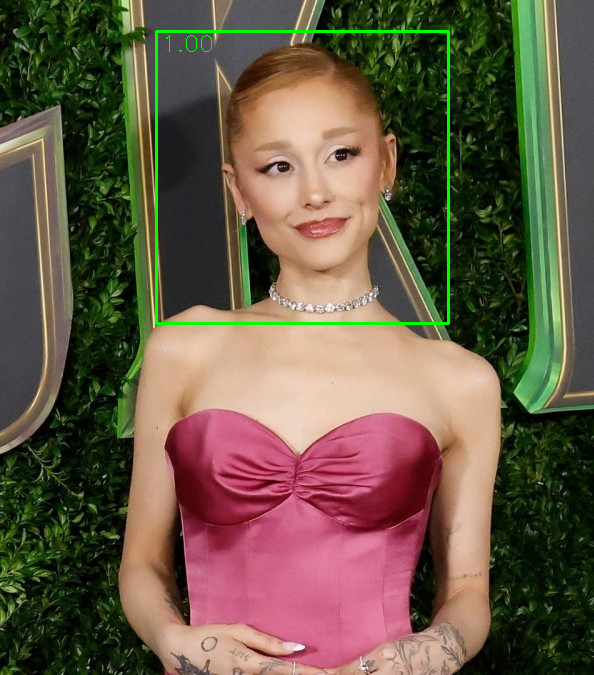

Processing hp.jpg...
Found 3 faces


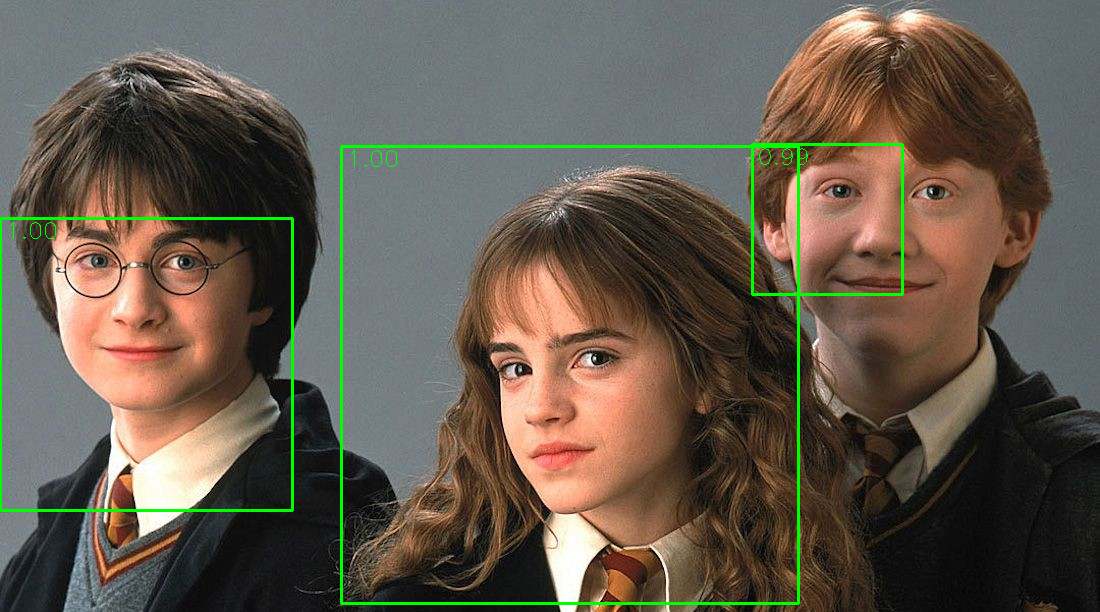

Processing himym.jpeg...
Found 6 faces


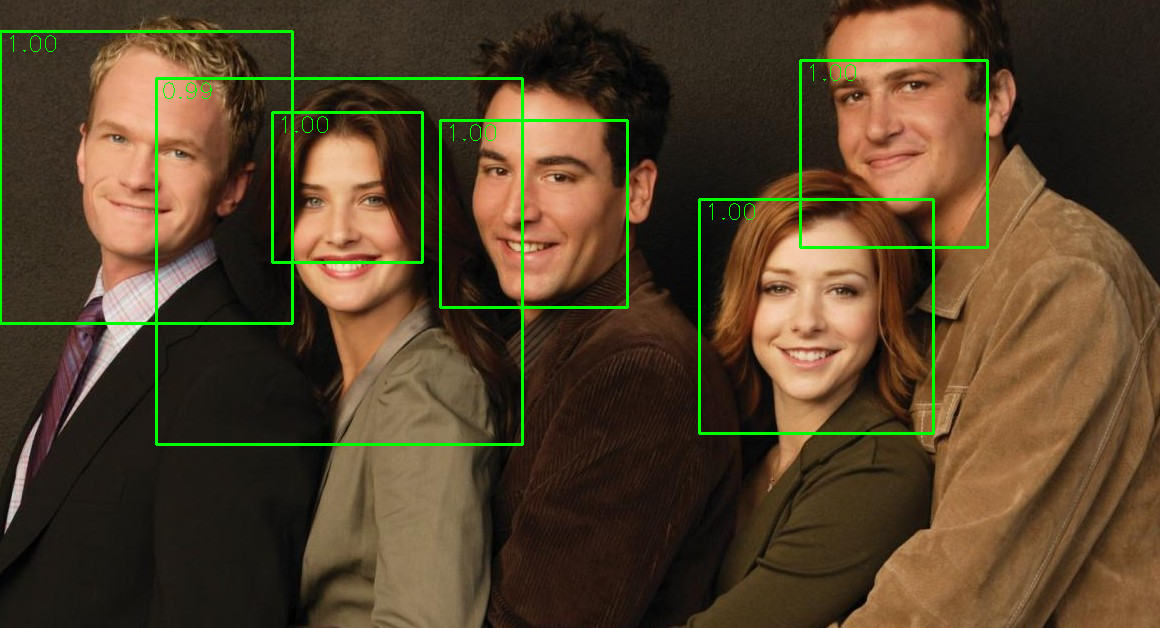

Processing maneskin (1).jpg...
Found 5 faces


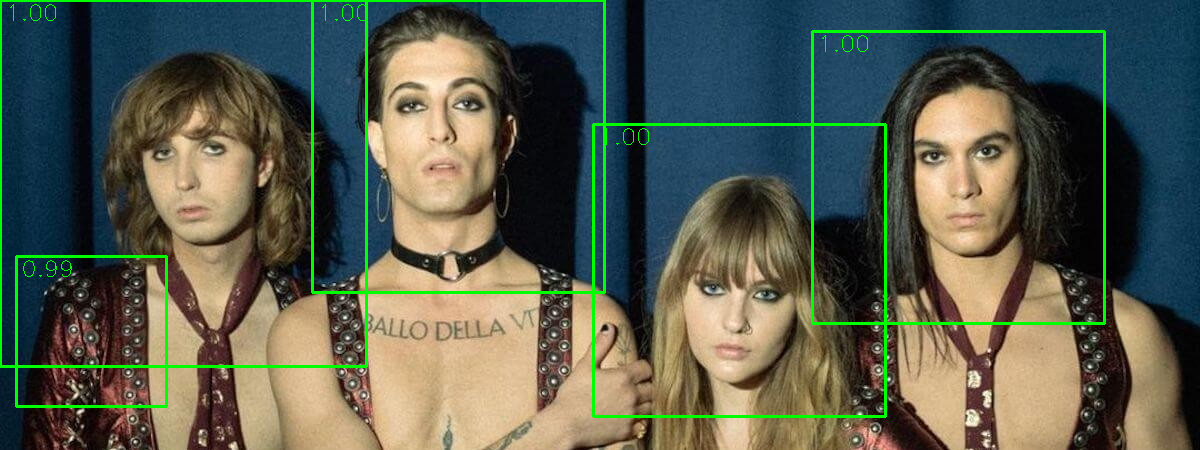

Detection process completed


In [ ]:
if __name__ == '__main__':
    # Mount Google Drive
    drive.mount('/content/drive')

    try:
        # Load trained SVM model
        svm_model = joblib.load(MODEL_PATH)
        print("Model loaded successfully")

        # Process test images
        test_images = [f for f in os.listdir(TEST_IMAGES_DIR)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not test_images:
            print(f"No images found in {TEST_IMAGES_DIR}")
        else:
            # Process first 4 images as example
            for img_name in test_images[:4]:
                img_path = os.path.join(TEST_IMAGES_DIR, img_name)
                img = cv2.imread(img_path)

                if img is None:
                    print(f"Failed to load image: {img_path}")
                    continue

                print(f"Processing {img_name}...")
                faces = detect_faces(img, svm_model)
                print(f"Found {len(faces)} faces")
                display_detections(img, faces)

    except Exception as e:
        print(f"Error occurred: {str(e)}")
    finally:
        # Cleanup resources if needed
        print("Detection process completed")